In [1]:
# The Question: 
# What are the top features that affect the time to resolve a complaint? Do they change over time?


# Step 0: Import libraries

# For data manipulation -
import pandas as pd
import numpy as np
import random
from datetime import datetime
from collections import Counter

# For visualization - 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# For model construction
import xgboost
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import explained_variance_score

In [2]:
# Step 1 - Data Sampling

# This is a rich and complex dataset, and for that reason it makes sense to trim it down as much as possible.
# Additionally, attempting to cleanse and construct a model on the entire dataset would take an immense amount of time,
# so it is prudent to start with a random sample.

filename = '/PATH_TO_DATA/311_Service_Requests_from_2010_to_Present.csv'

def sample_data(filename, nrows, seed = 100):
    random.seed(seed)
    n = sum(1 for line in open(filename)) - 1 #number of records in file (excludes header)
    s = nrows #desired sample size
    skip = sorted(random.sample(xrange(1,n+1),n-s)) #the 0-indexed header will not be included in the skip list
    df = pd.read_csv(filename, skiprows=skip)
    return df

# Starting with just less than one million rows. This should be enough to get a good sense of each
# categorical distribution.
df = sample_data(filename, 999999)

print df.shape

/Users/etron/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (8,17,39,40,41,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


(999999, 53)


In [3]:
df.head()

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
0,37242535,09/20/2017 03:22:34 PM,09/26/2017 09:59:41 PM,HPD,Department of Housing Preservation and Develop...,PAINT/PLASTER,WALL,RESIDENTIAL BUILDING,11224,2920 WEST 21 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.575780,-73.987872,"(40.57578043130392, -73.98787245978288)"
1,37035573,08/26/2017 01:31:00 PM,09/02/2017 02:00:00 PM,DEP,Department of Environmental Protection,Noise,Noise: Construction Equipment (NC1),NaN,11423,193-15 NERO AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.721593,-73.772720,"(40.72159289616612, -73.77271965479808)"
2,37442590,10/16/2017 09:17:44 AM,10/16/2017 04:07:08 PM,NYPD,New York City Police Department,Blocked Driveway,Partial Access,Street/Sidewalk,11236,9317 SCHENCK STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.630082,-73.888778,"(40.63008248084971, -73.8887782265097)"
3,23587937,07/10/2012 09:58:39 AM,02/27/2013 12:00:00 AM,DOB,Department of Buildings,General Construction/Plumbing,Fence - None/Inadequate,NaN,11204,2084 60 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.618302,-73.981115,"(40.6183019323626, -73.9811145150932)"
4,36491833,06/19/2017 08:13:21 PM,06/19/2017 10:10:19 PM,NYPD,New York City Police Department,Blocked Driveway,Partial Access,Street/Sidewalk,10314,179 BRIDGETOWN STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.583442,-74.156351,"(40.58344248000311, -74.15635133487996)"


In [4]:
# Step 2 - Data Exploration and Cleansing

df = df.replace('Unspecified', np.NaN)
df.isnull().mean().round(4)

# With so many features, we should look to remove as many as possible prior to building models. A lot of columns 
# are populated mostly with nulls, let's trim these since they will not provide much value

Unique Key                        0.0000
Created Date                      0.0000
Closed Date                       0.0344
Agency                            0.0000
Agency Name                       0.0000
Complaint Type                    0.0000
Descriptor                        0.0105
Location Type                     0.2593
Incident Zip                      0.0696
Incident Address                  0.2207
Street Name                       0.2208
Cross Street 1                    0.3100
Cross Street 2                    0.3142
Intersection Street 1             0.8437
Intersection Street 2             0.8440
Address Type                      0.0470
City                              0.0693
Landmark                          0.9995
Facility Type                     0.7486
Status                            0.0000
Due Date                          0.5872
Resolution Description            0.0384
Resolution Action Updated Date    0.0210
Community Board                   0.0000
Borough         

In [5]:
# Although our dataset is quite rich, we also have quite a few columns missing 99.9% of the data. For a first round
# of model building, I want to only see features that have are well populated, not too complex, and hopefully have
# some sort of relatable context. With that in mind, I am happy to trim as many features as I can. 

def drop_null(df, perc):
    nulls = dict(df.isnull().sum())
    drop = []
    size = df.shape[0]

    for f in nulls.keys():
        if nulls[f]/float(size) > perc:
            drop.append(f)

    return df.drop(drop, axis = 1)

trimmed = drop_null(df, 0.7)

trimmed.isnull().mean()

Unique Key                        0.000000
Created Date                      0.000000
Closed Date                       0.034377
Agency                            0.000000
Agency Name                       0.000000
Complaint Type                    0.000000
Descriptor                        0.010490
Location Type                     0.259263
Incident Zip                      0.069573
Incident Address                  0.220732
Street Name                       0.220796
Cross Street 1                    0.310041
Cross Street 2                    0.314167
Address Type                      0.046994
City                              0.069284
Status                            0.000005
Due Date                          0.587192
Resolution Description            0.038437
Resolution Action Updated Date    0.020982
Community Board                   0.000000
Borough                           0.081169
X Coordinate (State Plane)        0.105484
Y Coordinate (State Plane)        0.105484
Park Boroug

In [6]:
# Step 3 - Feature Engineering

# There is no feature for the time to resolve a complaint. It will need to be constructed from the available features. 
# Total duration to resolve a complaint can be defined as follows:
#   -> Total Duration = Closed Date - Created Date
# Also to get trends over time, we can extract the year of creation date

def time_delta(df, t1, t2, name, y = 'Year'):
    durations = []
    year = []
    for i in range(df.shape[0]):
        try:
            created = datetime.strptime(df[t1][i], '%m/%d/%Y %I:%M:%S %p')
            year.append(str(created.year))
            closed = datetime.strptime(df[t2][i], '%m/%d/%Y %I:%M:%S %p')
            duration = closed - created
            durations.append(duration.total_seconds()/(60.0 * 60)) # in hours
            
        except TypeError:
            # This error gets thrown if strptime tries to read a missing value. We can easily remove these afterwards.
            durations.append('null')
            
    df[name] = durations
    df[y] = year

time_delta(trimmed, 'Created Date', 'Closed Date', 'Duration')

# Remove entries where we do not have a Closed Date
trimmed = trimmed[trimmed['Duration'] != 'null'].reset_index(drop = True)
trimmed['Duration'] = pd.to_numeric(trimmed['Duration'])
print trimmed.shape
trimmed.head()

(965622, 30)


,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Park Borough,School Not Found,Latitude,Longitude,Location,Duration,Year
0,37242535,09/20/2017 03:22:34 PM,09/26/2017 09:59:41 PM,HPD,Department of Housing Preservation and Develop...,PAINT/PLASTER,WALL,RESIDENTIAL BUILDING,11224,2920 WEST 21 STREET,...,BROOKLYN,987619.0,149049.0,BROOKLYN,NaN,40.575780,-73.987872,"(40.57578043130392, -73.98787245978288)",150.618611,2017
1,37035573,08/26/2017 01:31:00 PM,09/02/2017 02:00:00 PM,DEP,Department of Environmental Protection,Noise,Noise: Construction Equipment (NC1),NaN,11423,193-15 NERO AVENUE,...,QUEENS,1047250.0,202254.0,QUEENS,NaN,40.721593,-73.772720,"(40.72159289616612, -73.77271965479808)",168.483333,2017
2,37442590,10/16/2017 09:17:44 AM,10/16/2017 04:07:08 PM,NYPD,New York City Police Department,Blocked Driveway,Partial Access,Street/Sidewalk,11236,9317 SCHENCK STREET,...,BROOKLYN,1015122.0,168852.0,BROOKLYN,N,40.630082,-73.888778,"(40.63008248084971, -73.8887782265097)",6.823333,2017
3,23587937,07/10/2012 09:58:39 AM,02/27/2013 12:00:00 AM,DOB,Department of Buildings,General Construction/Plumbing,Fence - None/Inadequate,NaN,11204,2084 60 STREET,...,BROOKLYN,989493.0,164541.0,BROOKLYN,NaN,40.618302,-73.981115,"(40.6183019323626, -73.9811145150932)",5558.022500,2012
4,36491833,06/19/2017 08:13:21 PM,06/19/2017 10:10:19 PM,NYPD,New York City Police Department,Blocked Driveway,Partial Access,Street/Sidewalk,10314,179 BRIDGETOWN STREET,...,STATEN ISLAND,940821.0,151879.0,STATEN ISLAND,N,40.583442,-74.156351,"(40.58344248000311, -74.15635133487996)",1.949444,2017


In [7]:
# Looking at our new feature, we can see that something is not right; all durations should be >= 0

print np.mean(trimmed['Duration'])

# It turns out that there are only a handful (relatively) of these troublesome rows where we can't trust 
# Closed/Created Date. We can remove these and move foward.

trimmed = trimmed[trimmed['Duration']>=0].reset_index(drop = True)
print trimmed.shape

print np.mean(trimmed['Duration'])

-53.9654438837
(951197, 30)
341.463305382


In [8]:
# Step 4 - Choosing Features for Encoding

# There are still a lot of columns with a fair amount of missing values, can we trim this down further?
#   -> Some features contain semi-redundant data, a large portion of features are related to location
#        - Latitude, Longitude, Location 
#        - Community Board, Borough, Park Borough
#        - Incident Zip, Incident Address, Street Name, Cross Street 1, Cross Street 2

# While it is plausible that location specific data has an impact on complaint resolution, there is no need to have
# so many different types of it. Because we have such a complex data set, it would be efficient to try and remove
# as many of these features as possible, as their impact is likely to be collinear.

# Based on this logic, I chose the features below. They are all categorical, which means their complexity is a concern.
# The more complex a feature is, the more encoding it requires, and model construction becomes slower while 
# sacrificing stability. So to trim further, lets take a look at how many unique values they have.

features = ['Complaint Type', 'Descriptor', 'Location Type',
            'Agency','Agency Name', 'Address Type',
            'Borough','Incident Zip']

for f in features:
    print(f + ': %s' %(str(len(set(trimmed[f])))))

# Incident Zip and Descriptor are the most complex, but Descriptor is likely to contain relevant information. 
# Complaint Type might contain a lot of the same information as Descriptor for reduced complexity
# Agency is far less complex than Agency Name

Complaint Type: 253
Descriptor: 1383
Location Type: 129
Agency: 20
Agency Name: 589
Address Type: 6
Borough: 6
Incident Zip: 25358


In [9]:
# It would be ill-advised to encode all the complex variables, but perhaps we can get some use out of them. If
# certain feature values have high counts, they might be worth encoding. We can see the top counts with Counter -

for f in ['Complaint Type', 'Descriptor', 'Location Type',
            'Agency Name','Agency', 'Address Type',
            'Incident Zip']:
    print(f + ': ')
    print Counter(trimmed[f]).most_common(10)
    print '\n'
    
# Complaint Type and Descriptor appear to have some contextual overlap, but Descriptor's counts drop off quickly.
#    -> Use high-runners from Complaint Type
# Location Type seems to have the most unique values, this should definitely be used
# The high-runners for Agency and Agency Name are exact matches. Agency is the choice as the simplest feature.
# Incident Zip has high runners of ~ 1% of the sample, these are not usable right now

Complaint Type: 
[('Noise - Residential', 80849), ('HEATING', 52572), ('HEAT/HOT WATER', 45359), ('Street Condition', 44960), ('Blocked Driveway', 38023), ('PLUMBING', 35354), ('Street Light Condition', 34011), ('Illegal Parking', 32857), ('Water System', 29924), ('GENERAL CONSTRUCTION', 28352)]


Descriptor: 
[('Loud Music/Party', 78526), ('HEAT', 51624), ('ENTIRE BUILDING', 29753), ('No Access', 28623), ('Pothole', 27769), ('Street Light Out', 25282), ('Banging/Pounding', 22358), ('CEILING', 17376), ('APARTMENT ONLY', 15606), ('Loud Talking', 13401)]


Location Type: 
[('RESIDENTIAL BUILDING', 280049), (nan, 240142), ('Street/Sidewalk', 116244), ('Street', 85350), ('Residential Building/House', 84254), ('Sidewalk', 43406), ('Property Address', 10206), ('Club/Bar/Restaurant', 9201), ('Senior Address', 9033), ('Store/Commercial', 8458)]


Agency Name: 
[('Department of Housing Preservation and Development', 281072), ('New York City Police Department', 218202), ('Department of Transport

In [10]:
# Step 5 - Feature Encoding

# Agency and Borough are easy to create thanks to the get_dummies function in pandas:

final = pd.get_dummies(trimmed[['Year','Duration', 'Agency', 'Borough', 'Complaint Type', 'Location Type', 'Address Type']])


final.head()

,Duration,Year_2010,Year_2011,Year_2012,Year_2013,Year_2014,Year_2015,Year_2016,Year_2017,Agency_3-1-1,...,Location Type_Utility,Location Type_Vacant Building,Location Type_Vacant Land,Location Type_Vacant Lot,Location Type_Vehicle Lane,Address Type_ADDRESS,Address Type_BLOCKFACE,Address Type_INTERSECTION,Address Type_LATLONG,Address Type_PLACENAME
0,150.618611,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,168.483333,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
2,6.823333,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,5558.022500,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,1.949444,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0


In [11]:
# Step 6 - Model Construction
# The data is finally prepared for a model. I will use an XGBoost Regressor to predict the length of time it takes
# a complaint to be resolved. This is a gradient boosting algorithm which is currently considered to be best in it's
# class. I have constructed a function below that does the following:
#                1. Takes a random sample of a given size 'sample_size' from the data
#                2. Splits this sample into a training and test set
#                3. Builds a model on the training set, and plots the relative importance of each feature
#                4. Predicts the target values on the test set
#                5. Returns a score assessing how much of the variance in target values is explained by the model

def xgb_acc(df, sample_size, test_size, random_state = 69):
    
    random.seed(random_state)
    df = df.sample(sample_size)
    
    target = df['Duration']
    features = df.drop('Duration', axis = 1)
    
    X_train, X_test, y_train, y_test = train_test_split(features,
                                                        target,
                                                        test_size = test_size,
                                                        random_state = random_state)
    
    xgb = xgboost.XGBRegressor(n_estimators=100,
                           learning_rate=0.08,
                           gamma=0,
                           subsample=0.75,
                           colsample_bytree=1,
                           max_depth=7)
    
    xgb.fit(X_train, y_train)
    plot_importance(xgb, max_num_features=15)
    plt.show()
    pred = xgb.predict(X_test)

    return(explained_variance_score(y_test, pred))

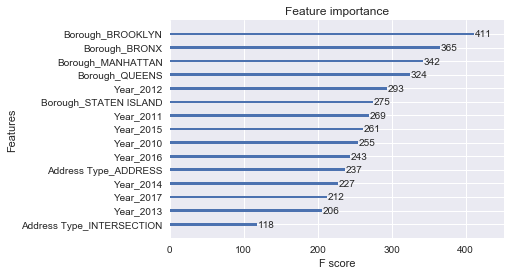

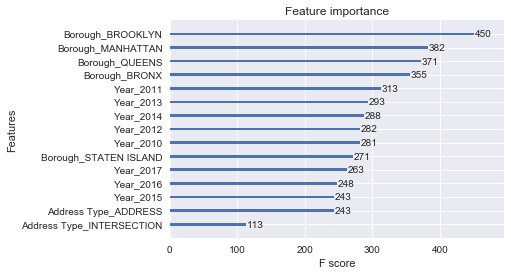

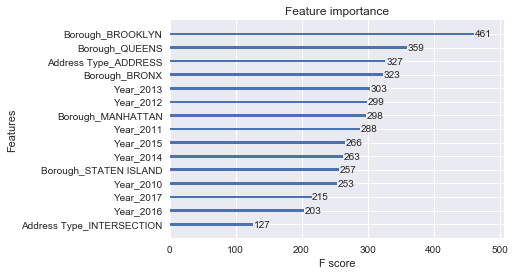

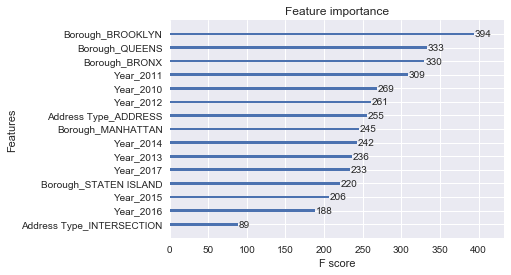

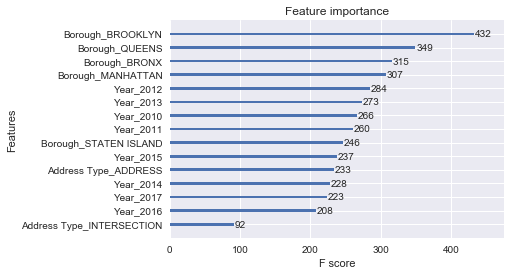

[0.26123013567993458, 0.25399954466678254, 0.32204460593059592, 0.27525911531224667, 0.29268463637843201]


In [12]:
# Running a model on the entire dataset will take a lot of time. Let's try running a handful of models on smaller
# subsamples to see if we can get a sense of the important features and their volatility.

acc = []
for i in range(5):
    acc.append(xgb_acc(final, 100000, 0.3, i))
    
print acc

[0.28100000000000003, 0.024]


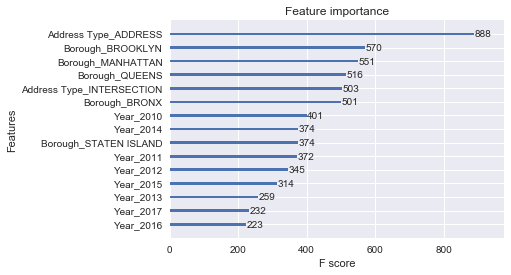

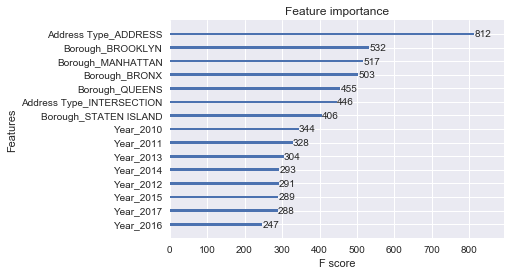

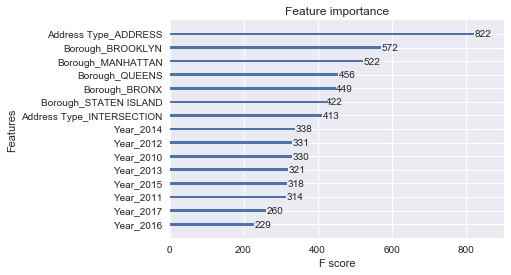

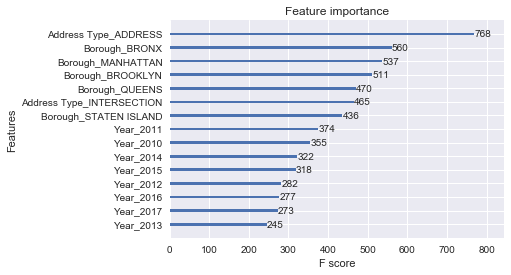

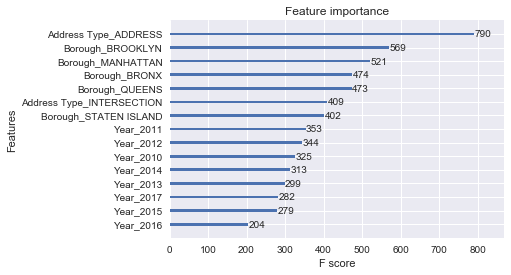

[0.13426518730065817, 0.17688530961381288, 0.17642095928131651, 0.14336310960352949, 0.16802075415290052]


In [13]:
print [np.mean(acc).round(3), np.std(acc).round(3)]

# Unfortunately, it appears that our feature choices are not the best predictors of time to resolve a complaint,
# explaining only about 30% of the variation in our test set values. That said, we did have some features distinguish
# themselves from the pack. In every single iteration, Borough and Year show up as the most important features, along
# with the individual Address Type of Address. Surprisingly, Complaint Type and Location Type barely sniff the top 15,
# and beg the question - is their complexity adding too much noise? Let's try again without these.

final = pd.get_dummies(trimmed[['Year','Duration', 'Agency', 'Borough', 'Address Type']])

acc = []
for i in range(5):
    acc.append(xgb_acc(final, 100000, 0.3, i))
    
print acc

Duration                                                  \
Year                 2010        2011        2012        2013        2014   
Borough                                                                     
BRONX          625.809574  392.646614  328.884517  350.308749  298.705417   
BROOKLYN       499.158733  395.242146  456.910192  428.867811  423.060383   
MANHATTAN      490.884820  390.549896  377.075192  347.296357  337.411924   
QUEENS         553.231366  513.565670  422.161912  418.486717  366.215374   
STATEN ISLAND  550.091681  597.702919  717.499779  522.857078  335.049250   

                                                   
Year                 2015        2016        2017  
Borough                                            
BRONX          248.163189  228.708450  160.941512  
BROOKLYN       402.106475  280.483734  152.359871  
MANHATTAN      327.263577  234.162646  164.813775  
QUEENS         399.383552  310.213852  158.800048  
STATEN ISLAND  260.617725  202.274314  136.953541

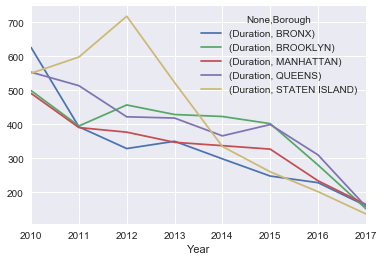

In [14]:
# Removing Complaint Type and Location Type weakens the model, so it is safe to say that at least some of their 
# categorical values can help improve a more comprehensive model. Address Type of Address clearly distinguishes itself 
# as the top feature, while Borough and Year consistently show up as second and third. It seems likely that time to 
# resolve a complaint has changed over the course of the past few years, so let's take a slightly closer look.

trimmed.groupby(['Year', 'Borough']).agg({'Duration': 'mean'}).unstack().plot()

trimmed.groupby(['Borough','Year']).agg({'Duration': 'mean'}).unstack()

# The trend is overwhelming; every single borough has seen their time to resolve a complaint plummet during this 
# eight year period. Almost all of the boroughs are falling from their peak in 2010, with the exception of Staten
# Island which peaked in 2012, and is now faster than all the other boroughs by a fair margin.

Duration                                      \
Year                        2010        2011        2012        2013   
Address Type_ADDRESS                                                   
0                     310.803354  258.774387  242.656959  232.507982   
1                     503.058127  465.870760  462.547487  435.420798   

                                                                      
Year                        2014        2015        2016        2017  
Address Type_ADDRESS                                                  
0                     267.847684  256.917064  196.846499  132.758381  
1                     387.978855  366.214879  273.808456  163.356001

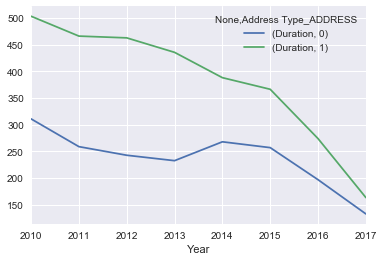

In [15]:
# And for Address Type_ADDRESS:

trimmed['Address Type_ADDRESS'] = final['Address Type_ADDRESS']

trimmed.groupby(['Year', 'Address Type_ADDRESS']).agg({'Duration': 'mean'}).unstack().plot()

trimmed.groupby(['Address Type_ADDRESS','Year']).agg({'Duration': 'mean'}).unstack()

# A similar trend follows Address Type_ADDRESS, but we can also see why this is an important feature; there is large 
# Duration gap between it and it's complement.

In [ ]:
# A Question of my own choosing?

# I think the above model can still be improved quite a bit, even if some of our features are not the strongest. The
# fact that Borough distinguished itself as an important feature despite low complexity shows that the location is
# an excellent lead in which to dig further, and the dataset is very accomodating given the plethora of available
# location data. Given more time, I would like to investigate Incident Zip even though it is our most complex feature
# of all. Rather than trying to create features out of each Zip Code, I would like to bin them into clusters,
# and then compare these clusters in a similar fashion to what I did with Borough. 

# As a completely separate question to investigate, I would like to look more closely at complaint types, and the 
# agencies that handle them. Are specific agencies head and shoulders above the rest at resolving complaints quickly? 
# Or is it also heavily dependent on location? Do certain angencies handle specific problems? Were there certain 
# time periods where an agency struggled or excelled due to unseen circumstances? Where did this improvement in
# Complaint resolution time come from? Initially I would cluster the complaint types and agencies, and look for the 
# high runners within each cluster to get a sense of how complaints are distributed. Then when accounting for the 
# passage of time, I would like to assess where efficiency improved.